In [1]:
from agrovoc import *
from agrovoc_utils import *
from rdflib import Graph
lang = 'en'
g = Graph()
a = Agrovoc(g, lang=lang)

Now loading the dictionary...


  0%|          | 14/36938 [00:00<30:40, 20.06it/s]

Now indexing the dictionary...


100%|██████████| 36938/36938 [04:38<00:00, 132.58it/s]


In [42]:
import json
import functools
import pandas as pd

file = pd.read_excel('https://github.com/Kipre/etude-technique/blob/master/2020_export_Projet_Indexation_Automatique_Notice_accesTI_public_depuis2010_20200204.xlsx?raw=true')
file = file.loc[file.LANGUE_DOC=="eng"]

def to_agrovoc(concepts):
    result = set()
    for concept in concepts:
        result = result.union(a.find_with_agrovoc(concept))
    return result

def intersection(set1, set2):
    inter_concept = set()
    for concept1 in set1 : 
        for concept2 in set2 : 
            if concept1[0] == concept2[0]:
                inter_concept.add(concept1)
                break
    return inter_concept           

class Callback:
    def __init__(self, message=""):
        self.average_accuracy=0
        self.average_precsision=0
        self.average_recovery=0
        self.average_nb_entities=0
        self.message = message
        self.examples = 0
        self.memory = []
        self.text=""
    def update(self, set1, List):
        set2 = to_agrovoc(List)
        self.text += ' '.join([word.replace(' ', '_') for _, word in set2])
        recovery = len(set2)/len(List)if len(List)>0 else 0
        res = intersection(set1, set2)
        accuracy = len(res)/len(set1)if len(set1)>0 else 0
        precsision = len(res)/len(set2)if len(set2)>0 else 0
        self.memory.append([accuracy, precsision, recovery])
        self.average_accuracy = (self.average_accuracy * self.examples + accuracy)/(self.examples + 1)
        self.average_nb_entities = (self.average_nb_entities * self.examples + len(List))/(self.examples + 1)
        self.average_precsision = (self.average_precsision * self.examples + precsision)/(self.examples + 1)
        self.average_recovery = (self.average_recovery * self.examples + recovery)/(self.examples + 1)
        self.examples += 1
        return("{} : {} , {} , {}".format(self.message, accuracy, precsision, recovery))
        


cagro = Callback("Agrovoc")
for i, row in file.iterrows():
    pdf = row['ACCES_TEXTE_INTEGRAL']
    descriptors = row["DESCRIPTEURS"]
    if type(descriptors) == str:
        descriptors = list(map(lambda x: x.strip(), row["DESCRIPTEURS"].split(";")))
    else:
        descriptors = []
        continue
    #agris = list(map(lambda x: x.strip().split(" et "), row["AGRIS"].split(";")))
    #agris = list(functools.reduce(lambda x, y: x + y, agris))
    metadata = to_agrovoc(descriptors)
    
    xml = pdf_to_xml(pdf)
    try:
        text_json = extract_entities(xml, lang=lang)
    except:
        print('Failed to process xml', xml[:100])
        continue
    try:
        text = json.loads(text_json)
    except:
        print(text_json[:100])
        continue
    entities = [part["rawName"].strip() for part in text["entities"]]
    categories = [part["category"].strip() for part in text["global_categories"]]
    ent_and_cat = entities + categories
    #ner_metadata = to_agrovoc(entities).union(to_agrovoc(categories))
    
    print(cagro.update(metadata, ent_and_cat))
  
    if len(cagro.memory) > 200:
        break
print(cagro.average_accuracy)



Agrovoc : 0.36363636363636365 , 0.11428571428571428 , 0.08215962441314555
Agrovoc : 0.6 , 0.03488372093023256 , 0.15114235500878734
Agrovoc : 0.5 , 0.009216589861751152 , 0.0633022170361727
Agrovoc : 0.5555555555555556 , 0.023923444976076555 , 0.22139830508474576
Agrovoc : 1.0 , 0.011764705882352941 , 0.07293007293007293
Agrovoc : 1.0 , 0.125 , 0.8421052631578947
Agrovoc : 1.0 , 0.01098901098901099 , 0.14748784440842788
Agrovoc : 1.0 , 0.03225806451612903 , 0.082010582010582
Agrovoc : 0.75 , 0.02459016393442623 , 0.0899042004421518
Failed to process xml [NO_BLOCKS] PDF parsing resulted in empty content
Agrovoc : 0.2 , 0.03125 , 0.24806201550387597
Agrovoc : 0.5714285714285714 , 0.06349206349206349 , 0.07875
Agrovoc : 0.75 , 0.02459016393442623 , 0.27415730337078653
Failed to process xml [NO_BLOCKS] PDF parsing resulted in empty content
Agrovoc : 0.5 , 0.07142857142857142 , 0.06349206349206349
Agrovoc : 0.0 , 0.0 , 0.04228486646884273
Agrovoc : 0.5714285714285714 , 0.06557377049180328 ,

Failed to process xml [BAD_INPUT_DATA] PDF to XML conversion failed with error code: 137
Agrovoc : 0.2 , 0.10526315789473684 , 0.20430107526881722
Agrovoc : 0.041666666666666664 , 0.05 , 0.037243947858473
Agrovoc : 0.3333333333333333 , 0.025210084033613446 , 0.07225258044930176
Agrovoc : 0.4666666666666667 , 0.042682926829268296 , 0.0876068376068376
Agrovoc : 0.5 , 0.14814814814814814 , 0.226890756302521
Agrovoc : 0.7692307692307693 , 0.08264462809917356 , 0.06456776947705443
Agrovoc : 0.5 , 0.022222222222222223 , 0.3125
Failed to process xml [TIMEOUT] PDF to XML conversion timed out
Agrovoc : 0.4666666666666667 , 0.051094890510948905 , 0.15765247410817032
Agrovoc : 0.6470588235294118 , 0.102803738317757 , 0.08649959579628133
Agrovoc : 0.45454545454545453 , 0.0684931506849315 , 0.15869565217391304
Agrovoc : 0.8 , 0.23529411764705882 , 0.25
Agrovoc : 0.375 , 0.04918032786885246 , 0.08390646492434663
Agrovoc : 0.3684210526315789 , 0.03932584269662921 , 0.13556740289413557
Agrovoc : 0.384

ConnectionError: HTTPConnectionPool(host='agritrop.cirad.fr', port=80): Max retries exceeded with url: /588136/1/Perspective_33_Daquino_ENG.pdf (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f21d2650d50>: Failed to establish a new connection: [Errno -3] Temporary failure in name resolution'))

In [43]:
print(cagro.average_accuracy, cagro.average_precsision, cagro.average_recovery, cagro.average_nb_entities)
print(len(cagro.memory))

0.4861221433600428 0.06181866738904937 0.150135227084343 842.4424778761062
113


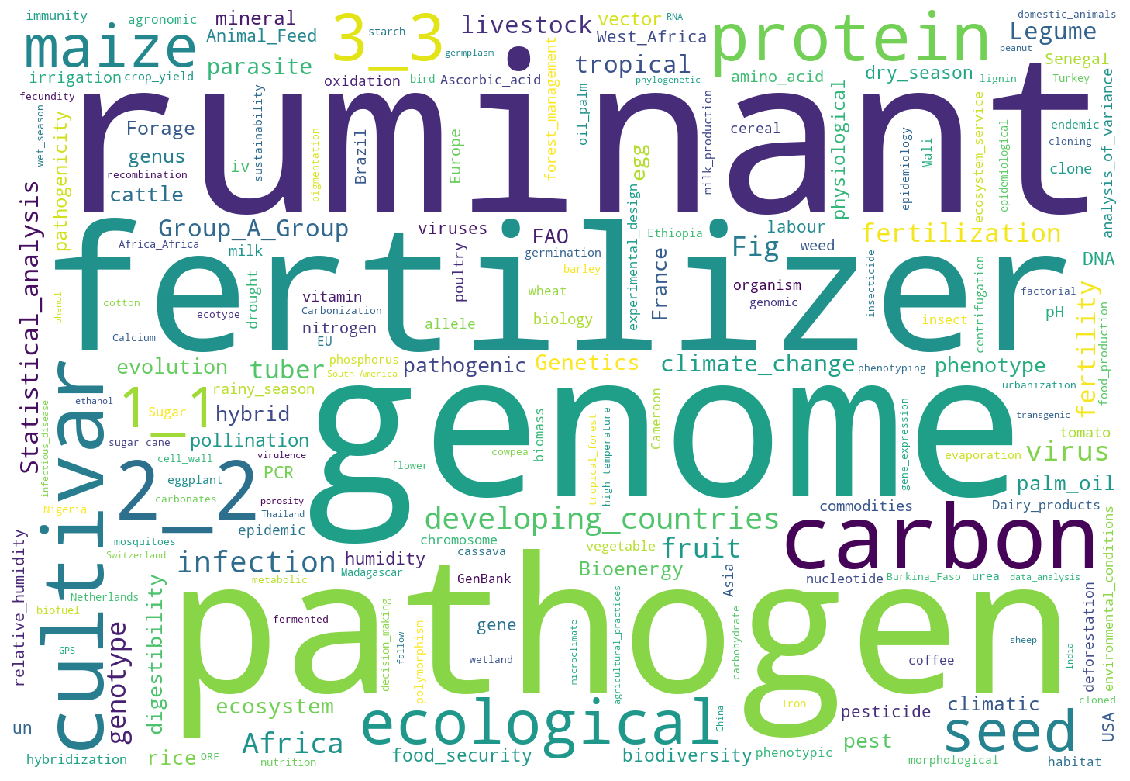

In [44]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20, 15))
img = WordCloud(width=1440, height=990, margin= 10, background_color='white').generate(cagro.text)
ax.imshow(img)
plt.axis('off')
plt.savefig('resources/wordclouden.png')

In [45]:
tips = pd.DataFrame(cagro.memory, columns=['Accuracy', 'Precision', 'Recovery'])
tips.to_csv('en_metrics.csv', index=False)